# Optimizing the eigen computation
## For Kaggle's NCAA competition

We've seen how to use the computation of a dominant eigenvector to obtain a rough ranking of competitors from a set of paired computations. We're going to use that procedure to help us generate a submission to [Kaggle's March Madness 2016 competition](https://www.kaggle.com/c/march-machine-learning-mania-2016/). All the data we'll use is available via the [Get the data](https://www.kaggle.com/c/march-machine-learning-mania-2016/data) link at the top of that page, though, you have to be signed in to actually download it. You can sign in via Google or Facebook, so it's not so hard. Either way, *none of the code in this notebook will work, unless it lives in the same directory as the Kaggle data*.

To have any chance, though, we'll have to tweak our algorithm. To do so, we'll introduce a number of parameters whose choices affect the outcome. Since we know Kaggle's scoring procedure and a smaller score is a better score, we'll run a numerical minimization procedure to attempt to find the best choice of parameters.

One issue to consider is how we might interpret the eigenvector in terms of probabilities. We'll see that it might make sense to scale the simple choice of probabilities that we've used to this point. We'll also take seeds into account. One nice thing about this is that it's not too hard to compute the historical probability that, say, a five seed beats a twelve seed. Ultimately, we'll take a weighted average of these two things. The proper weight ratio is, again, a parameter worth tweaking.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt

# NumPy - which is standard by now
import numpy as np 

# A sparse matrix representation
from scipy.sparse import dok_matrix

# An eigenvalue computer for sparse matrices
from scipy.sparse.linalg import eigs

# A data reader
import csv

# Time a lengthy computation
from time import time

# New! We'll need to optimize our procedure.
from scipy.optimize import minimize

### Historical win probabilities by seed

Kaggle provides two files that can help us compute how likely a team with one seed is to beat a team with a different seed: `TourneySeeds.csv`, which tells us how each team was seeded in very tournament from 1985-2015, and `TourneyCompactResults.csv`, which tells us the results of all the games played in all thouse tournaments. Let's read that data in and set up matrix `seed_data` recording the results. In row i and column j will be how many times a team with seed i beat a team with seed j.

In [2]:
seed_data = np.zeros((16,16))
all_seed_info = {}
seeds_handle = open('TourneySeeds.csv', 'r')
seeds_reader = csv.DictReader(seeds_handle, delimiter=',')
tourney_handle = open('TourneyCompactResults.csv', 'r')
tourney_reader = csv.DictReader(tourney_handle, delimiter=',')
seed_line = next(seeds_reader)
tourney_line = next(tourney_reader)
for year in range(1985, 2016):
    seed_dict = {}
    year = str(year)
    while seed_line['Season'] == year:
        team = seed_line['Team']
        seed = seed_line['Seed']
        seed = int(seed[1:3])
        seed_dict[team] = seed
        all_seed_info[year] = seed_dict
        seed_line = next(seeds_reader)
    while tourney_line['Season'] == year:
        w_seed = seed_dict[tourney_line['Wteam']]
        l_seed = seed_dict[tourney_line['Lteam']]
        seed_data[w_seed-1,l_seed-1] = seed_data[w_seed-1,l_seed-1] + 1
        tourney_line = next(tourney_reader, {'Season':None})
n_games = tourney_reader.line_num - 1
seeds_handle.close()
tourney_handle.close()

np.set_printoptions(linewidth=90)
seed_data.astype(int)

array([[ 18,  33,  16,  39,  34,   7,   5,  52,  57,   4,   3,  19,   4,   0,   0, 124],
       [ 26,   2,  29,   3,   0,  24,  53,   2,   0,  26,  13,   1,   0,   0, 117,   0],
       [ 12,  18,   1,   4,   2,  38,   7,   2,   1,   9,  26,   0,   0, 104,   1,   0],
       [ 17,   4,   3,   1,  37,   2,   2,   3,   2,   2,   0,  21,  99,   0,   0,   0],
       [  7,   4,   1,  30,   1,   1,   0,   1,   1,   1,   0,  80,  11,   0,   0,   0],
       [  3,   7,  28,   2,   0,   0,   3,   0,   0,   4,  81,   0,   0,  13,   0,   0],
       [  1,  20,   5,   2,   0,   3,   0,   1,   0,  76,   0,   0,   0,   1,   2,   0],
       [ 13,   5,   0,   5,   2,   1,   1,   0,  63,   0,   1,   0,   1,   0,   0,   0],
       [  5,   1,   0,   0,   1,   0,   0,  61,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,  18,   4,   0,   0,   2,  48,   0,   0,   0,   0,   0,   0,   1,   4,   0],
       [  3,   1,  13,   0,   0,  43,   3,   0,   0,   2,   5,   0,   0,   5,   0,   0],
       [  0,   0,   0

For example, a twelve seed has beaten a five seed $44$ times out of $44+80 = 124$ attempts. Thus, we might say that the likelihood that a twelve seed beats a five seed is
$$\frac{44}{80+44} \approx 0.3548387.$$
As a check on our work, the following two numbers should be the same, as they both represent the total number of games:

In [3]:
(int(sum(sum(seed_data))), n_games)

(1983, 1983)

Using this, it should be easy to set up a function that tells us the probability that an $i$ seed beats a $j$ seed.

In [4]:
seed_data_total = np.transpose(seed_data)+seed_data
def seed_prob(i,j): return seed_data[i-1,j-1]/seed_data_total[i-1,j-1]
seed_prob(12,5)

0.35483870967741937

This looks great - when it works. This doesn't really help so much if 2 one seeds or 2 two seeds  meet in the final four. We also have little or no data in the unlikely event that certain rare matchups - happen. For example, who knew that the probability that a five seed beats a two seed was 100%!!

In [5]:
seed_prob(5,2)

1.0

In reality, this has only happened four times in the last thirty years and the five seed happens to have won all of those. The small sample size isn't too surprising, if you consider that both teams must advance to the regional semi-finals for this to happen.  As a result, we'll modify our `seed_prob` function a bit so that it only returns a result if at least 10 such games have been played.

In [6]:
seed_data_total = np.transpose(seed_data)+seed_data
def seed_prob(i,j):
    if i != j and seed_data_total[i-1,j-1] > 10:
        return seed_data[i-1,j-1]/seed_data_total[i-1,j-1]
    else:
        return 'insufficient data'
seed_prob(5,2)

'insufficient data'

### Reading in and setting up the data for the eigen computation

In [7]:
# Just need to read the teams in once
file_handle = open('Teams.csv', 'r')
reader = csv.DictReader(file_handle, delimiter=',')
teams = [
    {
        'team_id':line['Team_Id'], 
        'team_name':line['Team_Name']
    }
    for line in reader
]
file_handle.close()

In [8]:
# Read in and set up the data for a particular year
year = '2015'

# Load the regular season data
# Our eigen-computation will be based soley on this
file_handle = open('RegularSeasonCompactResults.csv', 'r')
reader = csv.DictReader(file_handle, delimiter=',')
games = [
    {
        'day':int(line['Daynum']),
        'win_id':line['Wteam'],
        'win_score':int(line['Wscore']),
        'lose_id':line['Lteam'],
        'lose_score':int(line['Lscore']),
        'win_loc':line['Wloc'],
        'num_ot':line['Numot']
    }
    for line in reader if line['Season'] == year
]
file_handle.close()
min_day = min([game['day'] for game in games])
max_day = max([game['day'] for game in games])

# Read in the results of that year's tournament
# We'll use this just for scoring our attempt.
file_handle = open('TourneyCompactResults.csv', 'r')
reader = csv.DictReader(file_handle, delimiter=',')
tourney_results = []
for line in reader:
    if line['Season'] == year:
        win_team = line['Wteam']
        lose_team = line['Lteam']
        tourney_results.append((win_team,lose_team))
file_handle.close()

team_dict = {}
for game in games:
    win_team = game['win_id']
    if win_team in team_dict:
        team_dict[win_team]['num_games'] = team_dict[win_team]['num_games']+1
    else:
        team_dict[win_team] = {'num_games':1}
    lose_team = game['lose_id']
    if lose_team in team_dict:
        team_dict[lose_team]['num_games'] = team_dict[lose_team]['num_games']+1
    else:
        team_dict[lose_team] = {'num_games':1}
n = len(team_dict)
cnt = 0
for team in team_dict:
    team_dict[team]['matrix_idx'] = cnt
    cnt = cnt+1
    pos = [team['team_id'] for team in teams].index(team)
    team_dict[team]['name'] = teams[pos]['team_name']
reverse_team_dict = dict([(team_dict[team]['matrix_idx'],team) for team in team_dict])

The previous input read in and set up some important data for us. Specifically, `games` is a list of dictionaries that look like so:

    {'day': 7,
     'lose_id': '1414',
     'lose_score': 65,
     'num_ot': '0',
     'win_id': '1228',
     'win_loc': 'H',
     'win_score': 79}

That's just one example that's pretty self-explanatory. Note that the `'win_id'` and `'lose_id'` refer to numeric strings assigned by Kaggle. There's a `team_dict` that gives us basic information about each team specified by Kaggle ID. The first few entries of `team_dict` look like so:

    {'1102': {'matrix_idx': 244, 'name': 'Air Force', 'num_games': 28},
     '1103': {'matrix_idx': 166, 'name': 'Akron', 'num_games': 34},
     '1104': {'matrix_idx': 45, 'name': 'Alabama', 'num_games': 32}, ... }

I guess that `'name'` and `'num_games`' are self explanatory. The `'matrix_idx'` key tells us how each team is associated with the game matrix.

### Setting up and using the simplest matrix
I guess the very simplest matrix we could use is to place the number of times that team $i$ beat team $j$ in row $i$ and column $j$. The dominant eigenvector then yields a (*very rough*) ranking of the teams. 

In [9]:
M = dok_matrix((len(team_dict),len(team_dict)))
for game in games:
    win_team = game['win_id']
    win_index = team_dict[win_team]['matrix_idx']
    lose_team = game['lose_id']
    lose_index = team_dict[lose_team]['matrix_idx']
    M[win_index,lose_index] = M[win_index,lose_index] + 1
value, vector = eigs(M, which = 'LM', k=1)
vector = abs(np.ndarray.flatten(vector.real))
order = list(vector.argsort())
order.reverse()
[team_dict[reverse_team_dict[k]]['name'] for k in order[:10]]

['Kentucky',
 'Villanova',
 'Duke',
 'Kansas',
 'Wisconsin',
 'Virginia',
 'Notre Dame',
 'Iowa St',
 'Arizona',
 'Maryland']

### Interpreting our rankings as probabilities

Super! But how can we use this to compute probabilities? For example, what's the probability that the top team Kentucky beats the 158th team, who happens to be Coastal Carolina?

In [10]:
team158_matrix_idx = order[158]
team158_kaggle_idx = reverse_team_dict[team158_matrix_idx]
team_dict[team158_kaggle_idx]['name']

'Coastal Car'

To this point, if the relative strengths according to the values in the dominant eigenvector are $s_0$ and $s_{100}$, we've been using

$$\frac{s_0}{s_0+s_{100}}.$$

While this makes *some* sense in that it at least satisfies the basics of probability theory, it yields the following probability estimate that Kansas would've beaten Coastal Carolina that year.

In [11]:
team0_matrix_idx = order[0]
team0_strength = vector[team0_matrix_idx]
team158_strength = vector[team158_matrix_idx]
team0_strength/(team0_strength + team158_strength)

0.8609637300416686

Clearly, the probability should be *much* higher - well over 90% and maybe 98 or 99%. I propose that we scale the probabilities with a function that looks something like so:

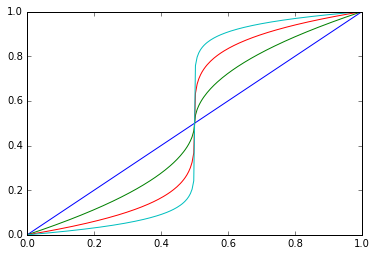

In [12]:
def scale(s,x): return 0.5+0.5*np.sign(x-0.5)*np.abs(2*x-1)**s

xs = np.linspace(0,1,200)
for s in (1,0.5,0.25,0.125):
    plt.plot(xs,scale(s, xs))

Thus, our previous computation might become something like so:

In [13]:
scale(0.1, team0_strength/(team0_strength + team158_strength))

0.98397102384161916

Of course, a reasonable value of $s$ is tweakable. Regardless, I emphasize that this is just a simple, intuitive tweak. A better approach would be to compare the correlation between eigen-strenghts and actual historical win percentage to obtain something like a confidence interval for our predictions. Maybe next year!

### A more detailed game matrix

Of course, the big question is - what *exactly* should the game matrix be in terms of all the information at our disposal?  If $M=(m_{ij})$, I guess we need formulae for $m_{ij}$ and $m_{ji}$ expressed in terms of the results of the games played between team $i$ and team $j$. The exact contribution to $m_{ij}$ from one particular game might depend on a number of factors, such as

  - The winner and loser
  - The score
  - When the game was played
  - Where the game was plaed
  - The total number of games played by each team

Of course, there are many other factors that might be considered, but the factors above are the ones we consider here and they are all in Kaggle's data. The specific formua we use below to determine the contribution of one game between team $i$ and team $j$ is

$$aw \times dw \frac{ww \times w + sw \times s/t}{n^p},$$

where

  - $aw$ is the away weight - i.e., how much an away victory is valued vs a home victory
  - $dw$ is the day weight - how much we weight a game in termes of when it was played
  - $ww$ is the win weight -  how much we weight victory
  - $w$ is one or zero depending on whether team $i$ won or lost this game
  - $sw$ is the score weight - how much we weight the score
  - $s$ is team $i$'s score
  - $t$ is the total score
  - $n$ is the number of games team $i$ played
  - $p$ is a non-negative exponent

### Running a trial

The `run_trial` function accepts a list of the above parameters, constructs the corresponding game matrix, compute the dominant eigenvector, and uses this to compute our the corresponding Kaggle score that would have resulted that year. We can optionally get extra information on the results.

In [14]:
def scale(s,x): return 0.5+0.5*np.sign(x-0.5)*np.abs(2*x-1)**s
def run_trial(parameters, extra_info=False):
    aw = parameters[0]
    sw = parameters[1]
    ww = parameters[2]
    n = parameters[3]
    day_weight = parameters[4]
    def dw(day):
        return day_weight + (1-day_weight)*(day-min_day)/(max_day-min_day)
    s = parameters[5]
    seed_weight = parameters[6]
    
    M = dok_matrix((len(team_dict),len(team_dict)))
    for game in games:
        day_weight = dw(game['day'])
        win_team = game['win_id']
        w_num_games = team_dict[win_team]['num_games']**n
        win_score = int(game['win_score'])
        win_index = team_dict[win_team]['matrix_idx']
        lose_team = game['lose_id']
        l_num_games = team_dict[lose_team]['num_games']**n
        lose_score = int(game['lose_score'])
        lose_index = team_dict[lose_team]['matrix_idx']
        total_score = win_score+lose_score
        if game['win_loc'] == 'H':
            whw = 1
            lhw = aw
        elif game['win_loc'] == 'A':
            whw = aw
            lhw = 1
        else:
            whw = 1
            lhw = 1
        M[win_index,lose_index] = M[win_index,lose_index] + whw*day_weight*ww/w_num_games + \
            (whw*day_weight*sw*win_score/total_score)/w_num_games
        M[lose_index,win_index] = M[lose_index,win_index] +  \
            (lhw*day_weight*sw*lose_score/total_score)/l_num_games
    value, vector = eigs(M, which = 'LM', k=1)
    vector = abs(np.ndarray.flatten(vector.real))
    order = list(vector.argsort())
    order.reverse()

    def eigen_prob1beats2(team1,team2):
        strength1 = vector[team_dict[team1]['matrix_idx']]
        strength2 = vector[team_dict[team2]['matrix_idx']]
        return scale(s, strength1/(strength1+strength2))
    
    def seed_prob1beats2(team1,team2):
        seed1 = all_seed_info[year][team1]
        seed2 = all_seed_info[year][team2]
        return seed_prob(seed1,seed2)
    
    def prob1beats2(team1,team2):
        eigen_p = eigen_prob1beats2(team1,team2)
        seed_p = seed_prob1beats2(team1,team2)
        if seed_p != 'insufficient data':
            return seed_weight*seed_p + (1-seed_weight)*eigen_p
        else:
            return eigen_p
    
    total = 0
    cnt = 0
    for result in tourney_results:
        total = total + np.log(prob1beats2(result[0],result[1]))
        cnt = cnt+1    
    score = -total/cnt
    if extra_info == True:
        extra_info_dict = {
            'ranking_vector': vector,
            'order': order,
            'p_function': prob1beats2,
            'rankings': [team_dict[reverse_team_dict[k]] for k in order]
        }
        return score, extra_info_dict
    else:
        return score

Note that `parameters` is the list of input parameters. We can use them like so:

In [15]:
# Give a little boost to an away win
aw = 1.3

# Value wins more than scores
sw = 1.6
ww = 0.3

# Regular normalization per Keener
p = 0.5

# Games from the beginning of the season count only 3/4 as much as current games.
dw = 0.75

s = 0.1

seed_w = 0.9

# Run it!
run_trial([aw,sw,ww,p,dw,s, seed_w])

0.5241818361929631

Here's what it looks like if you ask for the `extra_info`:

In [16]:
result, info = run_trial([aw,sw,ww,p,dw, s, seed_w], extra_info = True)

Thus, for example, we can use the function stored in `info['p_function']` to compute the probability that Kentucky beats Coastal Carolina.

In [17]:
kentucky_kaggle_idx = '1246'
coastal_kaggle_idx = '1157'
p_fun = info['p_function']
p_fun(kentucky_kaggle_idx, coastal_kaggle_idx)

0.99258548973269811

And we can score this `p_function`.

In [18]:
total = 0
cnt = 0
for result in tourney_results:
    total = total + np.log(p_fun(result[0],result[1]))
    cnt = cnt+1    
score = -total/cnt
score

0.52418183619296244

Remember that randomly assigning each team a 50/50 chance results in a score of $\log(2)\approx0.693$, so I guess we're getting better. To improve it more, let's try SciPy's `optimize.minimize` function. This takes an unfortunate amount of time, but will (hopefully) improve the reult.

In [19]:
# 2015
t = time()
result = minimize(run_trial, [aw,sw,ww,p,dw,s, seed_w], 
    bounds =  [(1,None), (0, None), (0.1, None), (0,None), (0,1),(0.00001,2),(0,1)])
time()-t

155.5796720981598

Took almost three minutes on my machine. Let's examine the result.

In [20]:
result

      fun: 0.49629542523100589
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.45279361e-06,   4.44089210e-08,  -1.33226763e-07,  -1.87627691e-06,
        -7.20822846e-03,   1.32283073e-05,   3.65263375e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 20
   status: 0
  success: True
        x: array([ 1.29361031,  1.60301168,  0.32379208,  0.49411197,  1.        ,  0.117935  ,
        0.53145065])

The result is essentially a dict with some extra methods for formatting. Of particular interest are the `fun` and `x` keys. Of course, we like that  `success` is `True`! The contents of `result['fun']` tells us the minimum that was found. Since this is about `0.496`, we see that we've improved on our initial attempt. Since $x$ is so often used as a generic input variable, `result['x']` tells us the input to achieve the minimum. Thus, the mimum was achieved with input parameters of about

    [1.293608, 1.60302087, 0.32379679, 0.49410859, 1.0, 0.11793583, 0.53145545]

Referring back to the purposes of these parameters, we find that an away win is valued a bit more than a home win, that scores count considerably more than just wins, that the normalization is only by about the square root of the number of games, that date played is ignored, that the probability scaling factor  is about $0.12$, and that the seed computation is weighted just a bit more than the eigen-computation.

What we really need to do is run this systematically for all years and compare the results.

### Creating a file submission
The filetype that Kaggle expects is detailed [on their evaluation page](https://www.kaggle.com/c/march-machine-learning-mania-2016/details/evaluation). The first few lines should look something like so:

    id,pred
    2016_1112_1114,0.91
    2016_1112_1122,0.96
    2016_1112_1124,0.82

We can create such a file as follows. First, we load the tourney seeds for this year, so we know who's in the tournament and so we can use our historical win probability function as part of our computation.

In [21]:
year = '2016'
seeds_handle = open('TourneySeeds.csv', 'r')
seeds_reader = csv.DictReader(seeds_handle, delimiter=',')
seed_dict = {}
for seed_line in seeds_reader:
    if seed_line['Season'] == year:
        team = seed_line['Team']
        seed = seed_line['Seed']
        seed = int(seed[1:3])
        seed_dict[team] = seed
seeds_handle.close()
teams_in = list(seed_dict.keys())
teams_in.sort()
pairs = [(teams_in[i], teams_in[j]) for i in range(68) for j in range(i+1,68)]
(len(pairs), pairs[-8:])

(2278,
 [('1453', '1462'),
  ('1453', '1463'),
  ('1455', '1458'),
  ('1455', '1462'),
  ('1455', '1463'),
  ('1458', '1462'),
  ('1458', '1463'),
  ('1462', '1463')])

Here's the game and team information for this year.

In [22]:
# Load the regular season data
# Our eigen-computation will be based soley on this
file_handle = open('RegularSeasonCompactResults.csv', 'r')
reader = csv.DictReader(file_handle, delimiter=',')
games = [
    {
        'day':int(line['Daynum']),
        'win_id':line['Wteam'],
        'win_score':int(line['Wscore']),
        'lose_id':line['Lteam'],
        'lose_score':int(line['Lscore']),
        'win_loc':line['Wloc'],
        'num_ot':line['Numot']
    }
    for line in reader if line['Season'] == year
]
file_handle.close()
min_day = min([game['day'] for game in games])
max_day = max([game['day'] for game in games])


# Set up the team_dict
team_dict = {}
for game in games:
    win_team = game['win_id']
    if win_team in team_dict:
        team_dict[win_team]['num_games'] = team_dict[win_team]['num_games']+1
    else:
        team_dict[win_team] = {'num_games':1}
    lose_team = game['lose_id']
    if lose_team in team_dict:
        team_dict[lose_team]['num_games'] = team_dict[lose_team]['num_games']+1
    else:
        team_dict[lose_team] = {'num_games':1}
n = len(team_dict)
cnt = 0
for team in team_dict:
    team_dict[team]['matrix_idx'] = cnt
    cnt = cnt+1
    pos = [team['team_id'] for team in teams].index(team)
    team_dict[team]['name'] = teams[pos]['team_name']
reverse_team_dict = dict([(team_dict[team]['matrix_idx'],team) for team in team_dict])

Rather than a `run_trial` function that computes our score (which we have no way of knowing yet), we write a `run_it` function that returns the `p_function` and `rankings` given particular input parameters.

In [23]:
def scale(s,x): return 0.5+0.5*np.sign(x-0.5)*np.abs(2*x-1)**s
def run_it(parameters):
    aw = parameters[0]
    sw = parameters[1]
    ww = parameters[2]
    n = parameters[3]
    day_weight = parameters[4]
    def dw(day):
        return day_weight + (1-day_weight)*(day-min_day)/(max_day-min_day)
    s = parameters[5]
    seed_weight = parameters[6]
    
    M = dok_matrix((len(team_dict),len(team_dict)))
    for game in games:
        day_weight = dw(game['day'])
        win_team = game['win_id']
        w_num_games = team_dict[win_team]['num_games']**n
        win_score = int(game['win_score'])
        win_index = team_dict[win_team]['matrix_idx']
        lose_team = game['lose_id']
        l_num_games = team_dict[lose_team]['num_games']**n
        lose_score = int(game['lose_score'])
        lose_index = team_dict[lose_team]['matrix_idx']
        total_score = win_score+lose_score
        if game['win_loc'] == 'H':
            whw = 1
            lhw = aw
        elif game['win_loc'] == 'A':
            whw = aw
            lhw = 1
        else:
            whw = 1
            lhw = 1
        M[win_index,lose_index] = M[win_index,lose_index] + whw*day_weight*ww/w_num_games + \
            (whw*day_weight*sw*win_score/total_score)/w_num_games
        M[lose_index,win_index] = M[lose_index,win_index] +  \
            (lhw*day_weight*sw*lose_score/total_score)/l_num_games
    value, vector = eigs(M, which = 'LM', k=1)
    vector = abs(np.ndarray.flatten(vector.real))
    order = list(vector.argsort())
    order.reverse()

    def eigen_prob1beats2(team1,team2):
        strength1 = vector[team_dict[team1]['matrix_idx']]
        strength2 = vector[team_dict[team2]['matrix_idx']]
        return scale(s, strength1/(strength1+strength2))
    
    def seed_prob1beats2(team1,team2):
        seed1 = seed_dict[team1]
        seed2 = seed_dict[team2]
        return seed_prob(seed1,seed2)
    
    def prob1beats2(team1,team2):
        eigen_p = eigen_prob1beats2(team1,team2)
        seed_p = seed_prob1beats2(team1,team2)
        if seed_p != 'insufficient data':
            return seed_weight*seed_p + (1-seed_weight)*eigen_p
        else:
            return eigen_p
    
    return {
        'ranking_vector': vector,
        'order': order,
        'p_function': prob1beats2,
        'rankings': [team_dict[reverse_team_dict[k]] for k in order]
    }

Here's an example and the resulting rankings.

In [24]:
attempt = run_it([1.1, 3, 2, 0.1, 0.8, 0.01, 0.8])
attempt['rankings'][:10]

[{'matrix_idx': 273, 'name': 'Kansas', 'num_games': 33},
 {'matrix_idx': 94, 'name': 'Villanova', 'num_games': 34},
 {'matrix_idx': 290, 'name': 'North Carolina', 'num_games': 34},
 {'matrix_idx': 237, 'name': 'Virginia', 'num_games': 33},
 {'matrix_idx': 193, 'name': 'Michigan St', 'num_games': 34},
 {'matrix_idx': 56, 'name': 'Kentucky', 'num_games': 34},
 {'matrix_idx': 137, 'name': 'Xavier', 'num_games': 32},
 {'matrix_idx': 254, 'name': 'West Virginia', 'num_games': 34},
 {'matrix_idx': 71, 'name': 'Miami FL', 'num_games': 32},
 {'matrix_idx': 149, 'name': 'Oklahoma', 'num_games': 32}]

Of course, to generate the submission file, we *really* need to use the `p_function` like so:

In [25]:
p_fun = attempt['p_function']
file_handle = open('submit.csv', 'w')
file_handle.write("id,pred\n")
for pair in pairs:
    line = "2016_" + pair[0] + "_" + pair[1] + ","
    p = p_fun(pair[0], pair[1])
    p = str(p)
    line = line + p
    line = line + "\t" + team_dict[pair[0]]['name'] + " - " + team_dict[pair[1]]['name']
    line = line + "\n"
    file_handle.write(line)
file_handle.close()

For example, here's the last line of our submission.

In [26]:
line

'2016_1462_1463,0.994273733698\tXavier - Yale\n'

## Scoring the file
Finally, let's track how we're doing while the tournament actually progresses. Since it's easier to work with team names that we might recognize, rather than Kaggle ID numbers, let's build a `team_to_id_dict` so that we can enter team names, which are then translated to ID numbers for scoring purposes. We can then enter a list of `actual_games`; each game is an ordered pair where the first team actually beat the second team.

In [27]:
team_to_id_dict = dict([(team_dict[team]['name'], team) for team in teams_in])
actual_games = [
    # Round one
    ('Duke', 'UNC Wilmington'),
    ('Butler', 'Texas Tech'),
    ('Connecticut', 'Colorado'),
    ('Iowa St', 'Iona'),
    ('Yale', 'Baylor'),
    ('Virginia', 'Hampton'),
    ('Kansas', 'Austin Peay'),
    ('Ark Little Rock', 'Purdue'),
    ('Miami FL', 'Buffalo'),
    ('Indiana', 'Chattanooga'),
    ('North Carolina', 'FL Gulf Coast'),
    ('Utah', 'Fresno St'),
    ('Providence', 'USC'),
    ('Wichita St', 'Arizona'),
    ('Kentucky', 'Stony Brook'),
    ('Gonzaga', 'Seton Hall'),
    ('Syracuse', 'Dayton'),
    ('Villanova', "UNC Asheville"),
    ('VA Commonwealth', 'Oregon St'),
    ('Hawaii', 'California'),
    ('MTSU', 'Michigan St'),
    ('Iowa', 'Temple'),
    ('Oklahoma', 'CS Bakersfield'),
    ('Maryland', 'S Dakota St'),
    ('Wisconsin', 'Pittsburgh'),
    ('SF Austin', 'West Virginia'),
    ('Texas A&M', 'WI Green Bay'),
    ('Oregon', 'Holy Cross'),
    ('Xavier', 'Weber St'),
    ('Northern Iowa', 'Texas'),
    ('Notre Dame', 'Michigan'),
    ("St Joseph's PA", 'Cincinnati'),
    
    # Round 2
    ('Miami FL', 'Wichita St'),
    ('Duke', 'Yale'),
    ('Indiana', 'Kentucky'),
    ('Iowa St', 'Ark Little Rock'),
    ('Virginia', 'Butler'),
    ('Kansas', 'Connecticut'),
    ('Gonzaga', 'Utah'),
    ('North Carolina', 'Providence'),
    ('Villanova', 'Iowa'),
    ('Notre Dame', 'SF Austin'),
    ('Oklahoma', 'VA Commonwealth'),
    ('Syracuse', 'MTSU'),
    ('Maryland', 'Hawaii'),
    ('Texas A&M', 'Northern Iowa'),
    ('Wisconsin', 'Xavier'),
    ('Oregon', "St Joseph's PA"),
    
    # Round 3
    ('Villanova', 'Miami FL'),
    ('Oklahoma', 'Texas A&M'),
    ('Kansas', 'Maryland'),
    ('Oregon', 'Duke'),
    ('Virginia', 'Iowa St'),
    ('North Carolina', 'Indiana'),
    ('Notre Dame', 'Wisconsin'),
    ('Syracuse', 'Gonzaga'),
    
    # Round 4 fiddle
    ('Oklahoma', 'Oregon') ,
    ('Villanova', 'Kansas'),
    ('Syracuse','Virginia'),
    ('North Carolina', 'Notre Dame'),
    
    # Final four
    ('Villanova', 'Oklahoma'),
    ('North Carolina', 'Syracuse'),
    
    # Championship game
    ('Villanova', 'North Carolina')
]
len(actual_games)

63

Now, we can can compute our score and print out some information on the specific games. Here are my results at the end of the tournament:

In [28]:
total = 0
cnt = 0
correct = []
incorrect = []
for actual_game in actual_games:
    actual_ids = [team_to_id_dict[team] for team in actual_game]
    win_id = actual_ids[0]
    actual_ids.sort()
    id1,id2 = actual_ids
    game_id = '2016_' + id1 + '_' + id2

    sub_handle = open('submissions/mcclure_submit1.csv')
    for line in sub_handle:
        if line[:14] == game_id:
            p = float(line.split(',')[1].strip())
            break
    if win_id == id2:
        p = 1-p
    sub_handle.close()
    total = total + np.log(p)
    cnt = cnt+1
    
    if p>1/2:
        correct.append((actual_game,p))
    else:
        incorrect.append((actual_game,p))

print(str(len(correct)) + ' games correct and ' + str(len(incorrect)) + ' incorrect')
print('Correct games:')
print('--------------')
for game_with_p in correct:
    print(game_with_p)
print('  ')
print('Incorrect games:')
print('--------------')
for game_with_p in incorrect:
    print(game_with_p)

score = -total/cnt
score

48 games correct and 15 incorrect
Correct games:
--------------
(('Duke', 'UNC Wilmington'), 0.827443191479)
(('Butler', 'Texas Tech'), 0.575543122922)
(('Connecticut', 'Colorado'), 0.589143591763)
(('Iowa St', 'Iona'), 0.824497446031)
(('Virginia', 'Hampton'), 0.999999)
(('Kansas', 'Austin Peay'), 0.99999)
(('Miami FL', 'Buffalo'), 0.8601316906600001)
(('Indiana', 'Chattanooga'), 0.710782788595)
(('North Carolina', 'FL Gulf Coast'), 0.999999)
(('Utah', 'Fresno St'), 0.85924928141)
(('Providence', 'USC'), 0.589478037059)
(('Kentucky', 'Stony Brook'), 0.832302628409)
(('Villanova', 'UNC Asheville'), 0.99)
(('VA Commonwealth', 'Oregon St'), 0.513307981699)
(('Iowa', 'Temple'), 0.675882221513)
(('Oklahoma', 'CS Bakersfield'), 0.99999)
(('Maryland', 'S Dakota St'), 0.713970063234)
(('Wisconsin', 'Pittsburgh'), 0.674373173287)
(('Texas A&M', 'WI Green Bay'), 0.862402731098)
(('Oregon', 'Holy Cross'), 0.999999)
(('Xavier', 'Weber St'), 0.9458026469204)
(('Notre Dame', 'Michigan'), 0.69953797

0.5500744155256394

I'm pretty happy about this. You can [look at the leaderboard](https://www.kaggle.com/c/march-machine-learning-mania-2016/leaderboard/public) to see that I came in 91st out of 598 entries (10 teams were excluded), which puts me well into the top quarter - a Kaggle accomplishment.

### Comparing to 538
[Five thirty eight](http://fivethirtyeight.com/) is an awesome group that uses statistics to make all kinds of predictions on sports, politics, and other things and reports on them as a subsidiary of ESPN. You can use theiry [interactive bracket](http://projects.fivethirtyeight.com/2016-march-madness-predictions/) to figure out what their entry *would be*, if they entered.  There are a couple of caveats in order:

1. There are only two digits of information for their probabilities. I'm not sure how much that might affect the results.
2. I'm pretty sure that the fivethirtyeight folks update their probability estimates between rounds, which should inflate their performance a bit.

In spite of these caveats, it's natural to wonder how they might have done. Again, using their interactive bracket, we can create the following CSV file:

	id,pred,team_name1,team_name2
	2016_1181_1423,0.85,Duke,UNC Wilmington
	2016_1139_1403,0.67,Butler,Texas Tech
	2016_1160_1163,0.36,Colorado,Connecticut
	2016_1233_1235,0.16,Iona,Iowa St
	2016_1124_1463,0.61,Baylor,Yale
	2016_1214_1438,0.02,Hampton,Virginia
	2016_1122_1242,0.01,Austin Peay,Kansas
	2016_1114_1345,0.16,Ark Little Rock,Purdue
	2016_1138_1274,0.14,Buffalo,Miami FL
	2016_1151_1231,0.12,Chattanooga,Indiana
	2016_1195_1314,0.02,FL Gulf Coast,North Carolina
	2016_1201_1428,0.13,Fresno St,Utah
	2016_1344_1425,0.62,Providence,USC
	2016_1112_1455,0.50,Arizona,Wichita St
	2016_1246_1392,0.93,Kentucky,Stony Brook
	2016_1211_1371,0.60,Gonzaga,Seton Hall
	2016_1173_1393,0.52,Dayton,Syracuse
	2016_1421_1437,0.04,UNC Asheville,Villanova
	2016_1333_1433,0.27,Oregon St,VA Commonwealth
	2016_1143_1218,0.83,California,Hawaii
	2016_1277_1292,0.95,Michigan St,MTSU
	2016_1234_1396,0.72,Iowa,Temple
	2016_1167_1328,0.04,CS Bakersfield,Oklahoma
	2016_1268_1355,0.79,Maryland,S Dakota St
	2016_1338_1458,0.37,Pittsburgh,Wisconsin
	2016_1372_1452,0.15,SF Austin,West Virginia
	2016_1401_1453,0.88,Texas A&M,WI Green Bay
	2016_1221_1332,0.02,Holy Cross,Oregon
	2016_1451_1462,0.06,Weber St,Xavier
	2016_1320_1400,0.30,Northern Iowa,Texas
	2016_1276_1323,0.34,Michigan,Notre Dame
	2016_1153_1386,0.61,Cincinnati,St Joseph's PA
	2016_1274_1455,0.41,Miami FL,Wichita St
	2016_1181_1463,0.71,Duke,Yale
	2016_1231_1246,0.38,Indiana,Kentucky
	2016_1114_1235,0.23,Ark Little Rock,Iowa St
	2016_1139_1438,0.21,Butler,Virginia
	2016_1163_1242,0.14,Connecticut,Kansas
	2016_1211_1428,0.48,Gonzaga,Utah
	2016_1314_1344,0.92,North Carolina,Providence
	2016_1234_1437,0.22,Iowa,Villanova
	2016_1323_1372,0.57,Notre Dame,SF Austin
	2016_1328_1433,0.84,Oklahoma,VA Commonwealth
	2016_1292_1393,0.28,MTSU,Syracuse
	2016_1218_1268,0.21,Hawaii,Maryland
	2016_1320_1401,0.24,Northern Iowa,Texas A&M
	2016_1458_1462,0.39,Wisconsin,Xavier
	2016_1332_1386,0.80,Oregon,St Joseph's PA
	2016_1274_1437,0.33,Miami FL,Villanova
	2016_1328_1401,0.61,Oklahoma,Texas A&M
	2016_1242_1268,0.73,Kansas,Maryland
	2016_1181_1332,0.43,Duke,Oregon
	2016_1235_1438,0.35,Iowa St,Virginia
	2016_1231_1314,0.27,Indiana,North Carolina
	2016_1323_1458,0.50,Notre Dame,Wisconsin
	2016_1211_1393,0.47,Gonzaga,Syracuse
	2016_1242_1437,0.59,Kansas,Villanova
	2016_1328_1332,0.54,Oklahoma,Oregon
	2016_1314_1323,0.82,North Carolina,Notre Dame
	2016_1393_1438,0.31,Syracuse,Virginia
	2016_1314_1438,0.70,North Carolina,Syracuse
	2016_1328_1437,0.46,Oklahoma,Villanova
    2016_1314_1437,0.54,North Carolina,Villanova

We can then score it.

In [29]:
total = 0
cnt = 0
correct = []
incorrect = []
for actual_game in actual_games:
    actual_ids = [team_to_id_dict[team] for team in actual_game]
    win_id = actual_ids[0]
    actual_ids.sort()
    id1,id2 = actual_ids
    game_id = '2016_' + id1 + '_' + id2

    sub_handle = open('five_thirty_eight.csv')
    for line in sub_handle:
        if line[:14] == game_id:
            p = float(line.split(',')[1].strip())
            break
    if win_id == id2:
        p = 1-p
    sub_handle.close()
    total = total + np.log(p)
    cnt = cnt+1
    
    if p>1/2:
        correct.append((actual_game,p))
    else:
        incorrect.append((actual_game,p))

print(str(len(correct)) + ' games correct and ' + str(len(incorrect)) + ' incorrect')
print('Correct games:')
print('--------------')
for game_with_p in correct:
    print(game_with_p)
print('  ')
print('Incorrect games:')
print('--------------')
for game_with_p in incorrect:
    print(game_with_p)

score = -total/cnt
score

46 games correct and 17 incorrect
Correct games:
--------------
(('Duke', 'UNC Wilmington'), 0.85)
(('Butler', 'Texas Tech'), 0.67)
(('Connecticut', 'Colorado'), 0.64)
(('Iowa St', 'Iona'), 0.84)
(('Virginia', 'Hampton'), 0.98)
(('Kansas', 'Austin Peay'), 0.99)
(('Miami FL', 'Buffalo'), 0.86)
(('Indiana', 'Chattanooga'), 0.88)
(('North Carolina', 'FL Gulf Coast'), 0.98)
(('Utah', 'Fresno St'), 0.87)
(('Providence', 'USC'), 0.62)
(('Kentucky', 'Stony Brook'), 0.93)
(('Gonzaga', 'Seton Hall'), 0.6)
(('Villanova', 'UNC Asheville'), 0.96)
(('VA Commonwealth', 'Oregon St'), 0.73)
(('Iowa', 'Temple'), 0.72)
(('Oklahoma', 'CS Bakersfield'), 0.96)
(('Maryland', 'S Dakota St'), 0.79)
(('Wisconsin', 'Pittsburgh'), 0.63)
(('Texas A&M', 'WI Green Bay'), 0.88)
(('Oregon', 'Holy Cross'), 0.98)
(('Xavier', 'Weber St'), 0.94)
(('Notre Dame', 'Michigan'), 0.6599999999999999)
(('Duke', 'Yale'), 0.71)
(('Iowa St', 'Ark Little Rock'), 0.77)
(('Virginia', 'Butler'), 0.79)
(('Kansas', 'Connecticut'), 0.86)


0.52634774043235943

That would put them in $8^{\text{th}}$ place. But, again, they updated their probabilities between rounds. I probably oughta check their placement after just the first round.

### A few final comments
It's interesting to note that this year was quite a bit harder than last. Only one entry scored less than $0.5$, while last year 148 out of only 341 entries were less than $0.5$.

You can read [NetProphet's interesting blog](http://netprophetblog.blogspot.com/) about this contest. (It's not just *my* obsession.)

**A potentially money winning strategy**

In [this blog post](http://netprophetblog.blogspot.com/2016/03/to-gamble-or-not-to-gamble-that-is.html), NetProphet indicates that you've got to gamble if you want to win money. Here's one way to think about it. The fifth place score was $0.524432$. That puts me at
$$0.550074 - 0.524432 = 0.025642$$
out of the money. And, frankly, I'm not that good at this. While we did some work tweaking the input parameters to make a substantial improvement over last year, a major weakness in our algorithm is that it doesn't assess probabilities well enough. I'll have to do some statistical analysis of the eigenvectors to generate some [prediction intervals](https://en.wikipedia.org/wiki/Prediction_interval) next year. The point is that it's really not too hard to generate a solid statistical approach to get you within 2 or 3 hundredths of a money placement. But, a best sensible approach almost certainly isn't going to get you money - it's much more likely to put you in the middle of the pack of the sensible approaches. So the question becomes, how do we give ourselves a chance to trim that extra 2 or 3 hundredths? 

Well, the fact is, something crazy is going to happen. You've just got to throw caution to the wind and try to guess one. It probably won't work, but at least you've got two entries to do it in. Scan your entries and find one where you've got about 80% confidence - oh, let's say California over Hawaii where I had Cal with probability $0.83$. Since that was an upset, at the end of the tournament, it contributed the following total to my score:

In [30]:
-np.log(0.17)/63

0.028126299078283734

If I had randomly picked that as an upset and assigned Hawaii over California with probability $1$, I would have improved my score by that amount and been in the money. If I had randomly picked MTSU over Michigan State, I would have been in second place. Of course, that's not likely apriori. But again, if you randomly choose one crazy guess for two entries several years in a row, you oughta hit something eventually.